In [1]:
import numpy as np
import pymc as pm # if using pymc >=4
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

import pandas as pd

import json

from pytensor.tensor import cumsum
import pytensor.tensor as at

from glob import glob

In [2]:
conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

ridx, cidx = np.triu_indices(len(conditions), k = 1)

times = np.linspace(-400, 1400, 901)
trim_idx = (times >= -250) & (times <= 1000)  # for trimming EEG down
times = times[trim_idx]

# details for compressing down the time bins, for faster computation
bin_starts = times[::5][:-1]
t_idx_starts = np.where([t in bin_starts for t in times])[0]

# defining delay period, excluding window when numbers never could have appeared
bin_ends = bin_starts+10
delay_period = (bin_starts >= 150) & (bin_ends <=1000)  # full delay is 150-1000ms

In [3]:
# drop_subs = ['003', '010', '014', '019', '021', '022']
drop_subs = []

In [4]:
# df["median_split"] = (df.response<df.response.quantile()).replace({True:1, False:2})
f = open('k_estimates.json')
k_res = json.load(f)
k_df = pd.DataFrame(pd.DataFrame(k_res).loc[['4','6','8']].mean())  # average across SS4-8
k_df['high_k'] = k_df[0] > k_df[0].quantile()
k_df

k_df = k_df[~k_df.index.isin(drop_subs)]  # drop subjects without chain convergence NOTE: this is hacky, and doesn't rebalance mean split
k_df

,0,high_k
001,4.591170,True
003,4.539708,True
004,3.805924,True
005,2.025422,False
007,2.535265,False
008,4.179959,True
009,4.163418,True
010,3.831069,True
011,3.994695,True
013,4.103589,True


In [5]:
rdm_files = sorted(glob('sub_rdms/sub_*.npy'))
rdm_files = [f for f in rdm_files if f.split('_')[-1].split('.')[0] not in drop_subs]
rdm_files

['sub_rdms/sub_001.npy',
 'sub_rdms/sub_003.npy',
 'sub_rdms/sub_004.npy',
 'sub_rdms/sub_005.npy',
 'sub_rdms/sub_007.npy',
 'sub_rdms/sub_008.npy',
 'sub_rdms/sub_009.npy',
 'sub_rdms/sub_010.npy',
 'sub_rdms/sub_011.npy',
 'sub_rdms/sub_013.npy',
 'sub_rdms/sub_014.npy',
 'sub_rdms/sub_015.npy',
 'sub_rdms/sub_019.npy',
 'sub_rdms/sub_021.npy',
 'sub_rdms/sub_022.npy',
 'sub_rdms/sub_023.npy',
 'sub_rdms/sub_025.npy',
 'sub_rdms/sub_026.npy',
 'sub_rdms/sub_027.npy',
 'sub_rdms/sub_028.npy',
 'sub_rdms/sub_029.npy',
 'sub_rdms/sub_030.npy',
 'sub_rdms/sub_031.npy',
 'sub_rdms/sub_032.npy',
 'sub_rdms/sub_033.npy',
 'sub_rdms/sub_034.npy']

In [6]:
# Number of Items in WM
WM_setsizes = np.array([int(cond[1]) if (cond[0] == 'M') else 0 for cond in conditions])
WMss_options = sorted(np.unique(WM_setsizes))
WM_setsize_map = {ss:i for i,ss in enumerate(WMss_options)}
cond_WMss_idx = np.array([WM_setsize_map[ss] for ss in WM_setsizes])

# Number of attended areas, assuming that people can filter our distractors
condition_ATTN = np.array([int(cond[1]) for cond in conditions])
ATTNss_options = sorted(np.unique(condition_ATTN))
ATTN_setsize_map = {ss:i for i,ss in enumerate(ATTNss_options)}
cond_ATTNss_idx = np.array([ATTN_setsize_map[ss] for ss in condition_ATTN])

# stimulus energy, carved up for a monotonic function
condition_stimEnergy = np.array([int(cond[1]) if cond[2]=='N' else 10 for cond in conditions])
stimEnergy_options = sorted(np.unique(condition_stimEnergy))
stimEnergy_map = {ss:i for i,ss in enumerate(stimEnergy_options)}
cond_stimEnergy_idx = np.array([stimEnergy_map[ss] for ss in condition_stimEnergy])

q = np.array([
    cond_WMss_idx[ridx], cond_WMss_idx[cidx],
    cond_ATTNss_idx[ridx], cond_ATTNss_idx[cidx],
    cond_stimEnergy_idx[ridx], cond_stimEnergy_idx[cidx],
]).T

In [7]:
def build_model(d, q):
    '''
    Build a model to estimate the WM and spatial attention functions with the following assumptions:
    1. The WM function is a guassian random walk, **is the same with or without placeholders**
    2. The spatial attention function is monotonic, **and is the same with or without placeholders**
    3. The stimulus energy function is monotonic

    **s indicate assumptions specific to this model

    Arguments
    ---------
    d : array of shape (n_distances,)
        The vectorized distances in upper (or lower) triangle of RDM
    q : array of shape (n_distances, n_regressors)
        Condition indices
    For this model the following column structure is expected:
    0. WM set size at first condition
    1. WM set size at second condition
    2. Spatial attention set size at first condition
    3. Spatial attention set size at second condition
    4. Stimulus energy at first condition
    5. Stimulus energy at second condition
    
    '''
    N = len(d)
    wmK = np.unique(q[:, :2]).size # number of WM set sizes
    attnK = np.unique(q[:, 2:4]).size # number of attended areas
    StimEnergyK = np.unique(q[:, 4:6]).size # number of stimulus energy levels
    nsub = np.unique(q[:, 7]).size  # number of subjects

    q = q.astype(int)
    sub_idx = q[:, 7].astype(int)
    k_group = q[:, 6].astype(int)
    
    # check that the quad indices are in the expected format
    assert np.min(q) == 0 
    assert q.shape[0] == N 
    assert (np.max(q[:, :2]) + 1) == wmK
    assert (np.max(q[:, 2:4]) + 1) == attnK
    assert (np.max(q[:, 4:6]) + 1) == StimEnergyK
    
    # steps between conditions we'd like to fit to data    
    coords = {
        'innovations_num_WM': np.arange(1, wmK),
        'innovations_num_Attn': np.arange(1, attnK), 
        'innovations_num_SE': np.arange(1, StimEnergyK),
        'subject': np.arange(0, nsub),
        'trial_num': np.arange(1, N + 1),
    }
    
    with pm.Model(coords = coords) as model:

        # prior on noise in RDM values
        sigma = pm.Exponential('sigma', lam=10)

        # WM prior on changes between successive levels in underlying function
        # assumes gaussian process, with random step between levels
        # population-level walk

        # high-k subjects
        sigma_innov_WM_hK = pm.Exponential('sigma_innov_WM_hK', lam=5)  # mean of 1/5 = 0.2 SDs
        sigma_init_WM_hK = pm.Exponential('sigma_init_WM_hK', lam=.2)  # mean of 1/0.2 = 5
        mu_WM_hK = pm.GaussianRandomWalk(
            'mu_minus_first_WM_hK',
            mu = 0,
            sigma = sigma_innov_WM_hK,
            init_dist = pm.Exponential.dist(lam=sigma_init_WM_hK),
            dims = ('innovations_num_WM',)
        )
        mu_WM_hK = pm.Deterministic('mu_WM_hK', pm.math.concatenate(([0.], mu_WM_hK)))

        # low-k subjects
        sigma_innov_WM_lK = pm.Exponential('sigma_innov_WM_lK', lam=5)  # mean of 1/5 = 0.2 SDs
        sigma_init_WM_lK = pm.Exponential('sigma_init_WM_lK', lam=.2)  # mean of 1/0.2 = 5
        mu_WM_lK = pm.GaussianRandomWalk(
            'mu_minus_first_WM_lK',
            mu = 0,
            sigma = sigma_innov_WM_lK,
            init_dist = pm.Exponential.dist(lam=sigma_init_WM_lK),
            dims = ('innovations_num_WM',)
        )
        mu_WM_lK = pm.Deterministic('mu_WM_lK', pm.math.concatenate(([0.], mu_WM_lK)))


        # # Spatial Attention is a random walk, like WM [** Many, many divergences, 2925 **]

        # # high-k subjects
        # sigma_innov_Attn_hK = pm.Exponential('sigma_innov_Attn_hK', lam=5)  # mean of 1/5 = 0.2 SDs
        # sigma_init_Attn_hK = pm.Exponential('sigma_init_Attn_hK', lam=.2)  # mean of 1/0.2 = 5
        # mu_Attn_hK = pm.GaussianRandomWalk(
        #     'mu_minus_first_Attn_hK',
        #     mu = 0,
        #     sigma = sigma_innov_Attn_hK,
        #     init_dist = pm.Exponential.dist(lam=sigma_init_Attn_hK),
        #     dims = ('innovations_num_Attn',)
        # )
        # mu_Attn_hK = pm.Deterministic('mu_Attn_hK', pm.math.concatenate(([0.], mu_Attn_hK)))

        # # low-k subjects
        # sigma_innov_Attn_lK = pm.Exponential('sigma_innov_Attn_lK', lam=5)  # mean of 1/5 = 0.2 SDs
        # sigma_init_Attn_lK = pm.Exponential('sigma_init_Attn_lK', lam=.2)  # mean of 1/0.2 = 5
        # mu_Attn_lK = pm.GaussianRandomWalk(
        #     'mu_minus_first_Attn_lK',
        #     mu = 0,
        #     sigma = sigma_innov_Attn_lK,
        #     init_dist = pm.Exponential.dist(lam=sigma_init_Attn_lK),
        #     dims = ('innovations_num_Attn',)
        # )
        # mu_Attn_lK = pm.Deterministic('mu_Attn_lK', pm.math.concatenate(([0.], mu_Attn_lK)))


        # spatial attention as a monotonoic function
        # assumes monotonic function via dirichlet distribution

        # high-k subjects
        beta_Attn_hk = pm.Exponential('beta_Attn_hK', lam=5)
        dir_Attn_hK = pm.Dirichlet('dir_Attn_hK', a = np.ones(attnK-1), dims = ('innovations_num_Attn',))
        mu_Attn_hK = pm.Deterministic('mu_Attn_minus_first_hK', cumsum(dir_Attn_hK))
        mu_Attn_hK = pm.Deterministic('mu_Attn_hK', beta_Attn_hk * pm.math.concatenate(([0.], mu_Attn_hK)))

        # low-k subjects
        beta_Attn_lk = pm.Exponential('beta_Attn_lK', lam=5)
        dir_Attn_lK = pm.Dirichlet('dir_Attn_lK', a = np.ones(attnK-1), dims = ('innovations_num_Attn',))
        mu_Attn_lK = pm.Deterministic('mu_Attn_minus_first_lK', cumsum(dir_Attn_lK))
        mu_Attn_lK = pm.Deterministic('mu_Attn_lK', beta_Attn_lk * pm.math.concatenate(([0.], mu_Attn_lK)))



        # Stimulus Energy as monotonic function, like spatial attention above

        # high-k subjects
        beta_SE_hk = pm.Exponential('beta_SE_hK', lam=5)
        dir_SE_hK = pm.Dirichlet('dir_SE_hK', a = np.ones(StimEnergyK-1), dims = ('innovations_num_SE',))
        mu_SE_hK = pm.Deterministic('mu_SE_minus_first_hK', cumsum(dir_SE_hK))
        mu_SE_hK = pm.Deterministic('mu_SE_hK', beta_SE_hk * pm.math.concatenate(([0.], mu_SE_hK)))

        # low-k subjects
        beta_SE_lk = pm.Exponential('beta_SE_lK', lam=5)
        dir_SE_lK = pm.Dirichlet('dir_SE_lK', a = np.ones(StimEnergyK-1), dims = ('innovations_num_SE',))
        mu_SE_lK = pm.Deterministic('mu_SE_minus_first_lK', cumsum(dir_SE_lK))
        mu_SE_lK = pm.Deterministic('mu_SE_lK', beta_SE_lk * pm.math.concatenate(([0.], mu_SE_lK)))
 
        
        # LIKELIHOOD FUNCTIONn

        # start by getting difference scores between pairs of conds based on WM and attn set sizes
        mu_i_WM = (k_group * mu_WM_hK[q[:, 0]]) + ((1-k_group) * mu_WM_lK[q[:, 0]])
        mu_j_WM = (k_group * mu_WM_hK[q[:, 1]]) + ((1-k_group) * mu_WM_lK[q[:, 1]])
        mu_delta_WM = pm.math.abs(mu_i_WM - mu_j_WM)

        mu_i_Attn = (k_group * mu_Attn_hK[q[:, 2]]) + ((1-k_group) * mu_Attn_lK[q[:, 2]])
        mu_j_Attn = (k_group * mu_Attn_hK[q[:, 3]]) + ((1-k_group) * mu_Attn_lK[q[:, 3]])
        mu_delta_Attn = pm.math.abs(mu_i_Attn - mu_j_Attn)

        mu_i_SE = (k_group * mu_SE_hK[q[:, 4]]) + ((1-k_group) * mu_SE_lK[q[:, 4]])
        mu_j_SE = (k_group * mu_SE_hK[q[:, 5]]) + ((1-k_group) * mu_SE_lK[q[:, 5]])
        mu_delta_SE = pm.math.abs(mu_i_SE - mu_j_SE)  # scale the difference for Stim Energy
        
        dist_est =  mu_delta_WM +\
                    mu_delta_Attn +\
                    mu_delta_SE

        # noise shrinks the crossnobis differences, so a subject-specific noise term
        # should be *multiplied* with rather than added to the predicted differences
        
        # sigma_sub = pm.Exponential('inverse_noise', 1, dims = ('subject',))
        pm.Normal(
            'd', 
            mu = dist_est, #* sigma_sub[sub_idx],
            sigma = sigma,
            observed = d, 
            dims = ("trial_num",)
        )
        
    return model

In [8]:
# build up distances and inputs

for i,f in enumerate(rdm_files):
    sub_id = f.split('_')[-1].split('.')[0]
    sub_rdms = np.load(f)
    sub_rdm_delay = sub_rdms[...,delay_period].mean(-1)

    sub_dists = sub_rdm_delay[ridx, cidx]

    sub_q = np.concatenate([q,
                            np.array([[k_df.loc[sub_id, 'high_k']] * q.shape[0]]).T,    # add column to differentiate k groups
                            np.array([[i] * q.shape[0]]).T                              # add column to index subjects
                            ], axis = 1)  

    if i == 0:
        pop_dists = sub_dists
        pop_q = sub_q
    else:
        pop_dists = np.concatenate((pop_dists, sub_dists))
        pop_q = np.concatenate((pop_q, sub_q), axis = 0)

print(pop_dists.shape, pop_q.shape)

(3120,) (3120, 8)


In [9]:
# fit model

model = build_model(pop_dists, pop_q)

with model:
    trace = pm.sample(
        5000, # real samples per chain
        tune = 3000, # warmup samples per chain
        chains = 4,
        target_accept = 0.95,
        random_seed = 42, 
        return_inferencedata = True,
        nuts_sampler="numpyro"
    )

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
# check the effective sample size
summary_table = az.summary(trace, var_names = ['mu_WM_hK', 'mu_WM_lK', 'mu_Attn_hK', 'mu_Attn_lK', 'mu_SE_hK', 'mu_SE_lK', 'sigma'])
summary_table

/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_WM_hK[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
mu_WM_hK[1],0.218,0.019,0.184,0.253,0.006,0.004,12.0,51.0,1.24
mu_WM_hK[2],0.039,0.181,-0.152,0.310,0.090,0.069,5.0,27.0,2.11
mu_WM_hK[3],0.028,0.216,-0.208,0.355,0.108,0.083,5.0,26.0,2.77
mu_WM_hK[4],0.027,0.220,-0.207,0.368,0.110,0.084,5.0,26.0,2.63
mu_WM_lK[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
mu_WM_lK[1],0.304,0.071,0.189,0.398,0.034,0.026,5.0,26.0,2.09
mu_WM_lK[2],0.144,0.150,-0.122,0.278,0.074,0.057,5.0,25.0,2.10
mu_WM_lK[3],0.125,0.119,-0.069,0.251,0.059,0.045,5.0,28.0,2.10
mu_WM_lK[4],0.129,0.142,-0.125,0.255,0.071,0.054,5.0,27.0,2.10


/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  wa

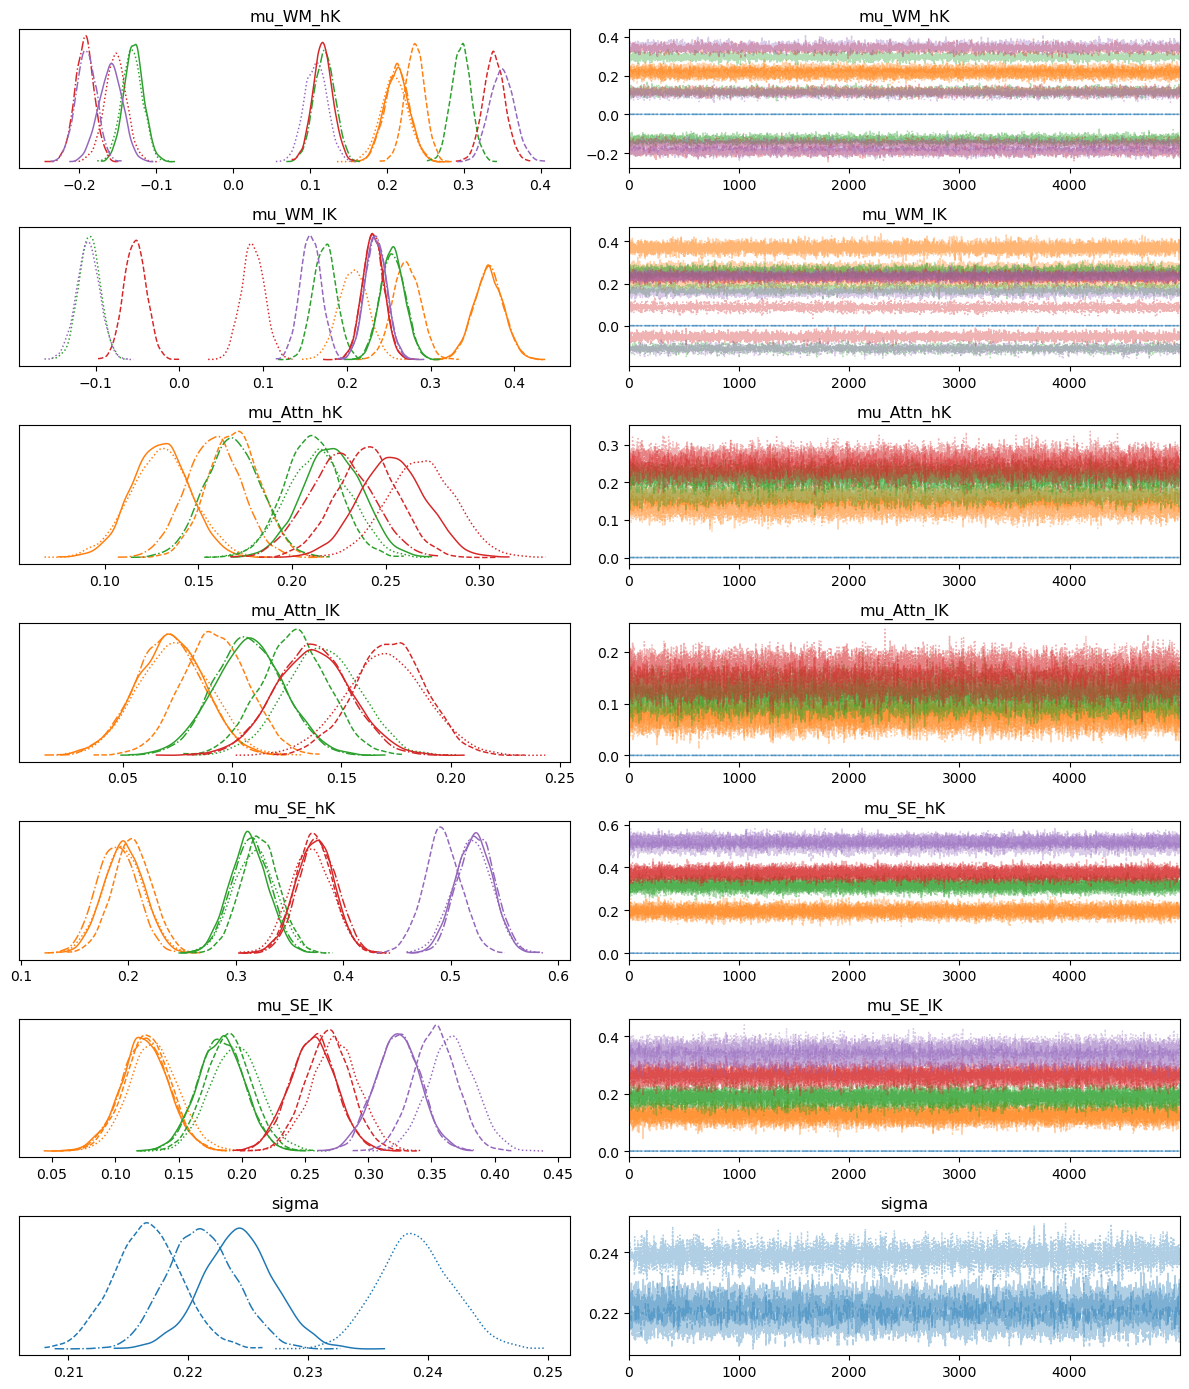

In [14]:
_ = pm.plot_trace(trace, var_names = ['mu_WM_hK', 'mu_WM_lK', 'mu_Attn_hK', 'mu_Attn_lK', 'mu_SE_hK', 'mu_SE_lK', 'sigma'])
plt.tight_layout()
plt.show()
plt.close()

# Pretty plots

In [15]:
trc = trace.posterior.stack(draws = ("chain", "draw"))

param_xs = {
    'mu_WM': [0, 2, 4, 6, 8],
    'mu_Attn': [2, 4, 6, 8],
    'mu_SE': [2, 4, 6, 8, 10]
}

param_xlabels = {
    'mu_WM': 'WM Set Size [0=Spatial Attention Task]',
    'mu_Attn': '# Attended Locations',
    'mu_SE': '# Stimuli in Display'
}

param_colors = {
    'mu_WM': 'red',
    'mu_Attn': 'blue',
    'mu_SE': 'orange'
}

param_titles = {
    'mu_WM': 'Working Memory Load Function',
    'mu_Attn': 'Spatial Attention Load Function',
    'mu_SE': 'Stimulus Energy Load Function'

}

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/2586484789.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_lower = az.hdi(high_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/2586484789.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_upper = az.hdi(high_param.T)[:, 1]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/2586484789.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  low_lower = az.hdi(low_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/2586484789.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but thi

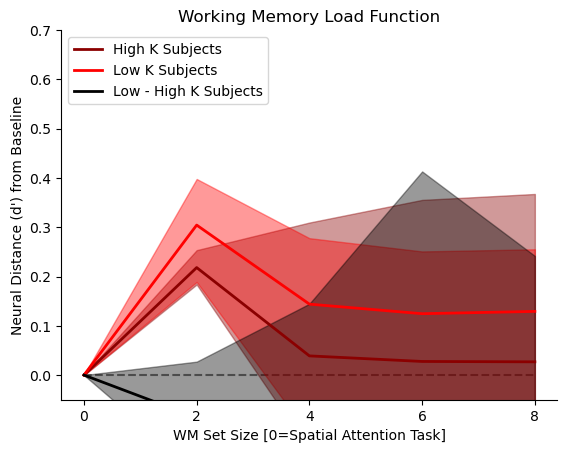

In [16]:
param = 'mu_WM'
mu_WM_high_k = trc['mu_WM_hK'].values
mu_WM_low_k =trc['mu_WM_lK'].values
mu_diff = mu_WM_high_k - mu_WM_low_k

high_param = mu_WM_high_k
high_lower = az.hdi(high_param.T)[:, 0]
high_upper = az.hdi(high_param.T)[:, 1]

low_param = mu_WM_low_k
low_lower = az.hdi(low_param.T)[:, 0]
low_upper = az.hdi(low_param.T)[:, 1]

diff_param = mu_diff
diff_lower = az.hdi(diff_param.T)[:, 0]
diff_upper = az.hdi(diff_param.T)[:, 1]

ax = sns.lineplot(x=param_xs[param], y=high_param.mean(1), label='High K Subjects', color = 'dark'+param_colors[param], linewidth=2)
plt.fill_between(param_xs[param], high_lower, high_upper, alpha = .4, color='dark'+param_colors[param])

sns.lineplot(x=param_xs[param], y=low_param.mean(1), label='Low K Subjects', color = param_colors[param], ax=ax, linewidth=2)
plt.fill_between(param_xs[param], low_lower, low_upper, alpha = .4, color=param_colors[param])

sns.lineplot(x=param_xs[param], y=diff_param.mean(1), label='Low - High K Subjects', color = 'black', ax=ax, linewidth=2)
plt.fill_between(param_xs[param], diff_lower, diff_upper, alpha = .4, color='black')

plt.hlines(0, 0, 8, linestyle='--', color='gray', zorder=-1)

plt.xticks(param_xs[param])
plt.xlabel(param_xlabels[param])
plt.ylim(-.05, .7)
plt.yticks(np.round(plt.yticks()[0], 1))
plt.ylim(-.05, .7)
plt.ylabel("Neural Distance (d') from Baseline")
plt.legend(loc='upper left')
plt.title(param_titles[param])
sns.despine()
# plt.savefig(f'figures/{param}_split_half.svg')
plt.show()
plt.close()

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1714702799.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_lower = az.hdi(high_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1714702799.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_upper = az.hdi(high_param.T)[:, 1]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1714702799.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  low_lower = az.hdi(low_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1714702799.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but thi

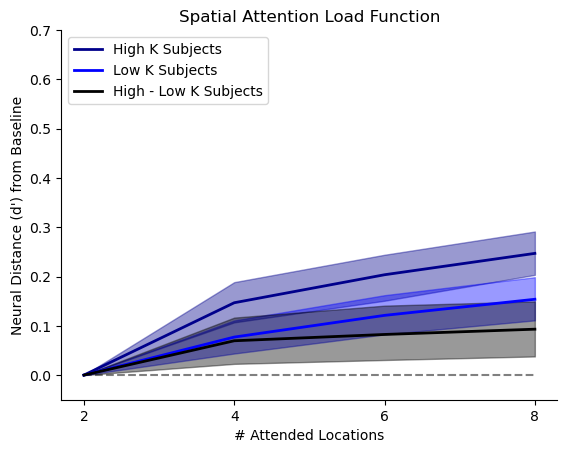

In [17]:
param = 'mu_Attn'

mu_attn_high_k = trc['mu_Attn_hK'].values
mu_attn_low_k = trc['mu_Attn_lK'].values
mu_diff = mu_attn_high_k - mu_attn_low_k

high_param = mu_attn_high_k
high_lower = az.hdi(high_param.T)[:, 0]
high_upper = az.hdi(high_param.T)[:, 1]

low_param = mu_attn_low_k
low_lower = az.hdi(low_param.T)[:, 0]
low_upper = az.hdi(low_param.T)[:, 1]

diff_param = mu_diff
diff_lower = az.hdi(diff_param.T)[:, 0]
diff_upper = az.hdi(diff_param.T)[:, 1]

ax = sns.lineplot(x=param_xs[param], y=high_param.mean(1), label='High K Subjects', color = 'dark'+param_colors[param], linewidth=2)
plt.fill_between(param_xs[param], high_lower, high_upper, alpha = .4, color='dark'+param_colors[param])

sns.lineplot(x=param_xs[param], y=low_param.mean(1), label='Low K Subjects', color = param_colors[param], ax=ax, linewidth=2)
plt.fill_between(param_xs[param], low_lower, low_upper, alpha = .4, color=param_colors[param])

sns.lineplot(x=param_xs[param], y=diff_param.mean(1), label='High - Low K Subjects', color = 'black', ax=ax, linewidth=2)
plt.fill_between(param_xs[param], diff_lower, diff_upper, alpha = .4, color='black')

plt.hlines(0, 2, 8, linestyle='--', color='gray', zorder=-1)

plt.xticks(param_xs[param])
plt.xlabel(param_xlabels[param])

plt.ylim(-.05, .7)
plt.yticks(np.round(plt.yticks()[0], 1))
plt.ylim(-.05, .7)
plt.ylabel("Neural Distance (d') from Baseline")
plt.legend(loc='upper left')
plt.title(param_titles[param])
sns.despine()
# plt.savefig(f'figures/{param}_split_half.svg')
plt.show()
plt.close()

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1432897108.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_lower = az.hdi(high_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1432897108.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  high_upper = az.hdi(high_param.T)[:, 1]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1432897108.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  low_lower = az.hdi(low_param.T)[:, 0]
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_78482/1432897108.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but thi

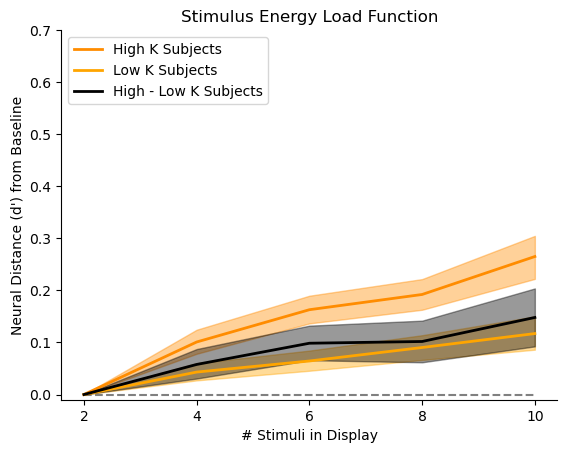

In [18]:
param = 'mu_SE'
mu_SE_high_k = trc['beta_SE_hK'].values[np.newaxis, :] *  trc['mu_SE_hK'].values
mu_SE_low_k = trc['beta_SE_lK'].values[np.newaxis, :] *  trc['mu_SE_lK'].values
mu_diff = mu_SE_high_k - mu_SE_low_k

high_param = mu_SE_high_k
high_lower = az.hdi(high_param.T)[:, 0]
high_upper = az.hdi(high_param.T)[:, 1]

low_param = mu_SE_low_k
low_lower = az.hdi(low_param.T)[:, 0]
low_upper = az.hdi(low_param.T)[:, 1]

diff_param = mu_diff
diff_lower = az.hdi(diff_param.T)[:, 0]
diff_upper = az.hdi(diff_param.T)[:, 1]

ax = sns.lineplot(x=param_xs[param], y=high_param.mean(1), label='High K Subjects', color = 'dark'+param_colors[param], linewidth=2)
plt.fill_between(param_xs[param], high_lower, high_upper, alpha = .4, color='dark'+param_colors[param])

sns.lineplot(x=param_xs[param], y=low_param.mean(1), label='Low K Subjects', color = param_colors[param], ax=ax, linewidth=2)
plt.fill_between(param_xs[param], low_lower, low_upper, alpha = .4, color=param_colors[param])

sns.lineplot(x=param_xs[param], y=diff_param.mean(1), label='High - Low K Subjects', color = 'black', ax=ax, linewidth=2)
plt.fill_between(param_xs[param], diff_lower, diff_upper, alpha = .4, color='black')

plt.hlines(0, 2, 10, linestyle='--', color='gray', zorder=-1)

plt.xticks(param_xs[param])
plt.xlabel(param_xlabels[param])
plt.ylim(-.01, .7)
plt.yticks(np.round(plt.yticks()[0], 1))
plt.ylim(-.01, .7)
plt.ylabel("Neural Distance (d') from Baseline")
plt.legend(loc='upper left')
plt.title(param_titles[param])
sns.despine()
# plt.savefig(f'figures/{param}_split_half.svg')
plt.show()
plt.close()

# old - from when inverse noise was included

In [ ]:
sub_scalars = trc['inverse_noise'].values
sub_scalars.shape

(26, 20000)

In [ ]:
high_k_scalars = sub_scalars[k_df.high_k.values, :].mean(0)
low_k_scalars = sub_scalars[~k_df.high_k.values, :].mean(0)

difference_of_scalars = high_k_scalars - low_k_scalars

In [ ]:
high_hdi = az.hdi(high_k_scalars)
low_hdi = az.hdi(low_k_scalars)
print(high_hdi, low_hdi)

[0.66932691 1.60952582] [0.60820302 1.56863291]


In [ ]:
az.hdi(difference_of_scalars)

array([-0.63718625,  0.74972631])

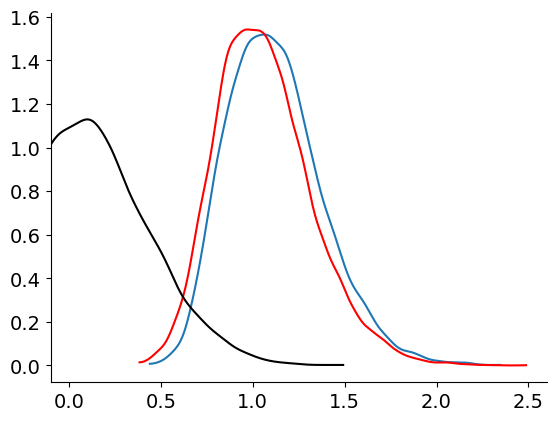

In [ ]:
az.plot_dist(high_k_scalars)
_ = az.plot_dist(low_k_scalars, color='red')
az.plot_dist(difference_of_scalars, color='black')
plt.xlim(-0.1, 2.6)
sns.despine()